# Predicting NYC Taxi Fares

# Goal

Predict the fare amount of a taxi ride in New York City, trying to improve on $5-8 Root Mean Square Error.

# Overview

In [75]:
import numpy as np
import pandas as pd
from pytz import all_timezones
from geopy import distance
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
import holidays
import datetime as dt
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 12, 6

### Read in the data

The training data has over 55 million records, due to time contraints we'll select small sample for model development.

In [2]:
test = pd.read_csv('~/Downloads/Equinox Case Study/test.csv')
train = pd.read_csv('~/Downloads/Equinox Case Study/train.csv')
sample = pd.read_csv('~/Downloads/Equinox Case Study/sample_submission.csv')

In [59]:
test.shape

(10000, 7)

In [63]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-01-15 22:15:33.0000002,2013-01-15 22:15:33 UTC,-73.964698,40.755988,-73.851317,40.725599,1
1,2014-04-26 10:52:00.0000001,2014-04-26 10:52:00 UTC,-73.975795,40.751695,-74.014270,40.702737,1
2,2011-12-05 08:58:23.0000002,2011-12-05 08:58:23 UTC,-73.918334,40.742913,-73.901899,40.748975,1
3,2009-06-19 16:13:57.0000002,2009-06-19 16:13:57 UTC,-73.998917,40.734303,-74.009172,40.735564,1
4,2014-09-15 16:33:00.00000080,2014-09-15 16:33:00 UTC,-73.808705,40.688525,-73.995820,40.758962,1


In [60]:
train.shape

(55413856, 9)

In [62]:
train.head()

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [61]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [5]:
train = train.reset_index()

In [192]:
df = train.sample(frac=.01, random_state=1)

Day and time will likely be important factors in model development, so we'll convert everything to appropriate time zones and identify key components like month of the year and hour of the day.

In [193]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_datetime'] = df.pickup_datetime.dt.tz_localize('UTC', ambiguous=True)
df['pickup_datetime'] = df.pickup_datetime.dt.tz_convert('US/Eastern')
df['pickup_year'] = df.pickup_datetime.dt.year
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_month_year'] = df.pickup_datetime.dt.to_period('M')
df['pickup_date'] = df.pickup_datetime.dt.date
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_day'] = df.pickup_datetime.dt.weekday
df['pickup_day_name'] = df.pickup_datetime.dt.weekday_name

### Great Circle distance between points

To start, we have pickup and dropoff coordinates for nearly every trip. Since cab fares accumulate a set rate per mile, we'll calculate the estimated straight line distance. This will be an underestimate of the true distance traveled by car, and does not account for traffic, etc. 

This should be, however, linearly correlated with fare to the extent that there is a flat rate per additional distance traveled in many instances.

In [194]:
def calculate_miles(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    try:
        return distance.great_circle(pickup, dropoff).miles
    except:
        return None

In [195]:
df['miles'] = df.apply(calculate_miles, axis=1)

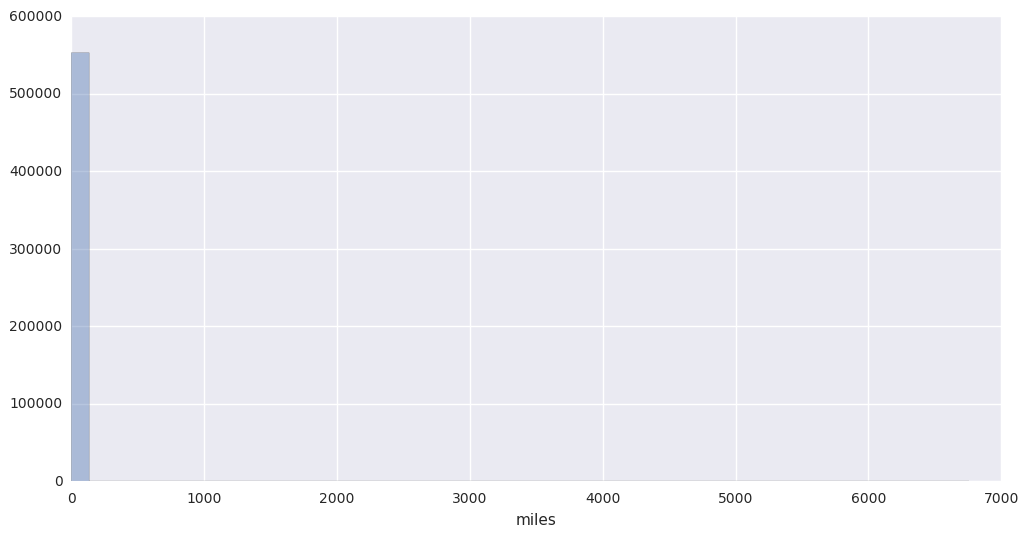

In [196]:
sns.distplot(df[(df.miles.notnull())]['miles'], kde=False)

There is clearly some inconsistent data here, with some outliers that will through off the data for 99% percent of the cases that we care about. A closer look shows that the vast majority of trips cover less that 50 miles, which also happeens to be the approximate distance to travel from Nassau County to Westchester County.

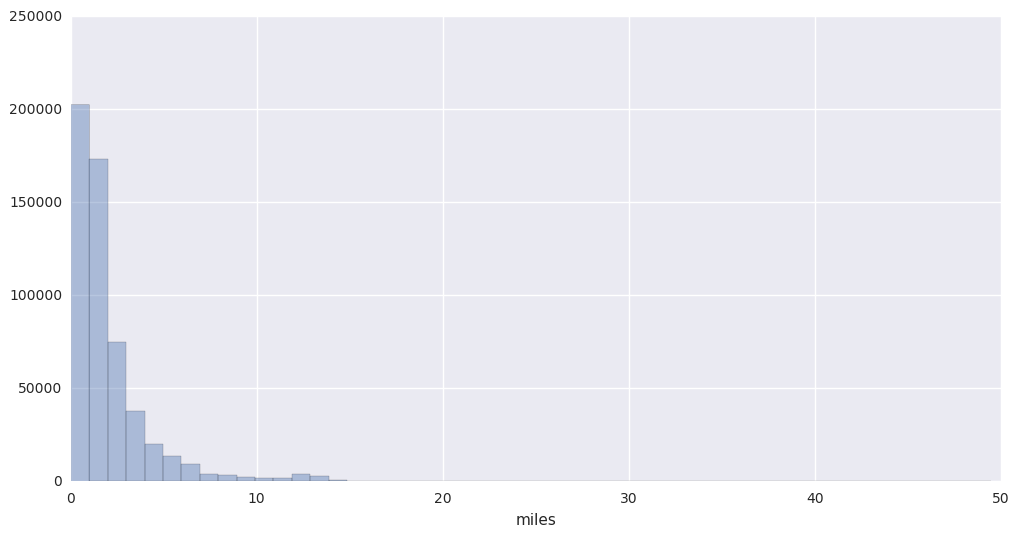

In [197]:
sns.distplot(df[(df.miles.notnull())&(df.miles<50)]['miles'], kde=False)

### Clean up

Since we're considering only NYC taxi data, we should ignore the few records where the coordinates fall far outside of the relevant region (potentially due to swapped coordinates) and the far amount is a negative number.

In [198]:
df.shape

(554139, 17)

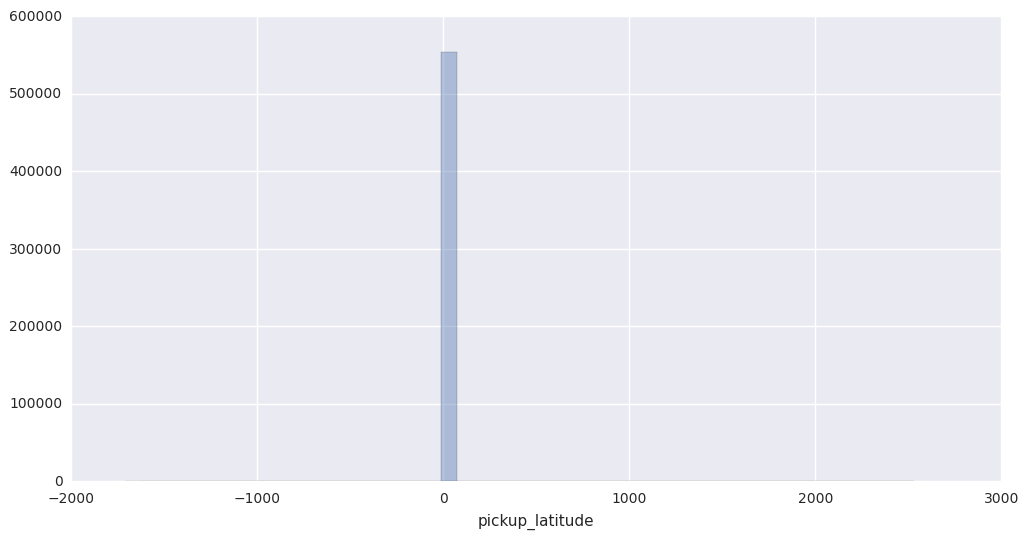

In [199]:
sns.distplot(df['pickup_latitude'], kde=False)

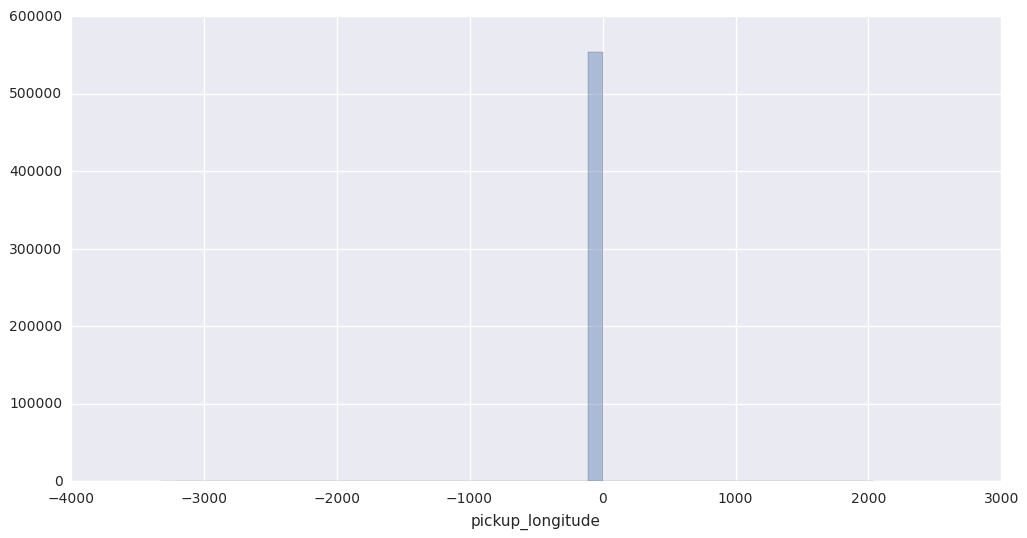

In [200]:
sns.distplot(df['pickup_longitude'], kde=False)

In [201]:
lat_range = (38, 42)
lon_range = (-76, -72)

In [202]:
df = df.loc[
    (df.pickup_latitude>lat_range[0])
    &(df.pickup_latitude<lat_range[1])
    &(df.pickup_longitude>lon_range[0])
    &(df.pickup_longitude<lon_range[1])
    &(df.dropoff_latitude>lat_range[0])
    &(df.dropoff_latitude<lat_range[1])
    &(df.dropoff_longitude>lon_range[0])
    &(df.dropoff_longitude<lon_range[1])]

In [203]:
df = df.loc[df.fare_amount > 0]

In [204]:
df.shape

(542649, 17)

In [205]:
df = df.loc[(df.miles.notnull())&(df.miles<20)]

In [206]:
df.shape

(542379, 17)

### Exploratory Data Analysis

Overall trips per month have remained relatively stable, with no obvious seasonal trends.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
 <a list of 79 Text xticklabel objects>)

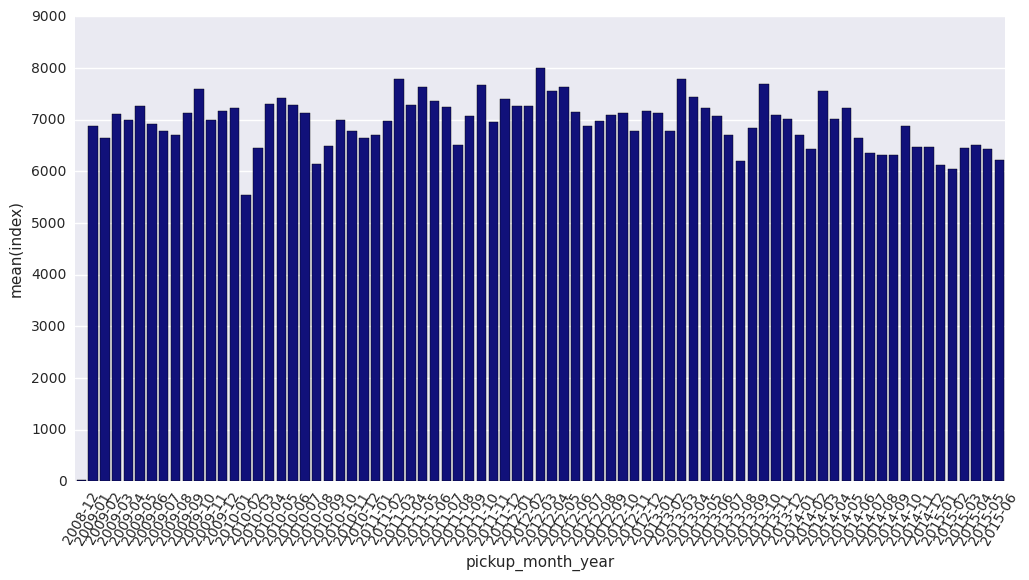

In [207]:
sns.barplot(
    x='pickup_month_year',
    y='index',
    data=df.groupby(['pickup_month_year']).agg({'index':'count'}).reset_index(),
    color='darkblue')
plt.xticks(rotation=60)

Average fare amonuts have steadily increased, especially increasing starting in mid-2012. If we wanted to model this as a time series, worth considering a potential change point if fare structure changed at this point.

According to NY Times (2012): Taxi fares rose ~17%, from 40 cents per 1/5 mile to 50 cents.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
 <a list of 79 Text xticklabel objects>)

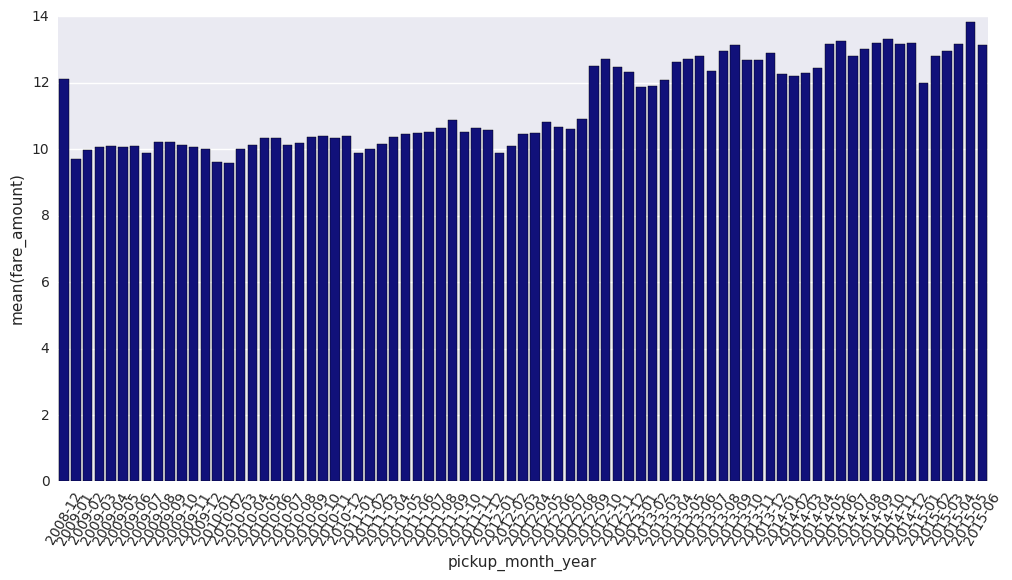

In [208]:
sns.barplot(
    x='pickup_month_year',
    y='fare_amount',
    data=df.groupby(['pickup_month_year']).agg({'fare_amount':'mean'}).reset_index(),
    color='darkblue')
plt.xticks(rotation=60)

Median fare amounts reflect a similar sharp increase in mid-2012.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
 <a list of 79 Text xticklabel objects>)

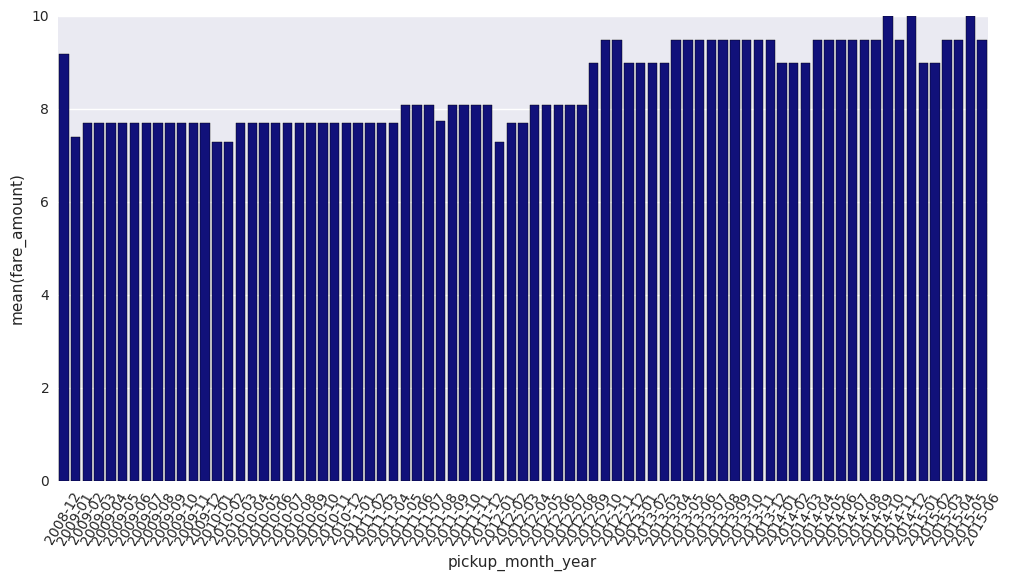

In [209]:
sns.barplot(
    x='pickup_month_year',
    y='fare_amount',
    data=df.groupby(['pickup_month_year']).agg({'fare_amount':'median'}).reset_index(),
    color='darkblue')
plt.xticks(rotation=60)

Since it does not make sense for fare amount to be below 0, the data is highly right skewed, with few fares that are absurdly high and the rest within a reasonable range of $5-15.

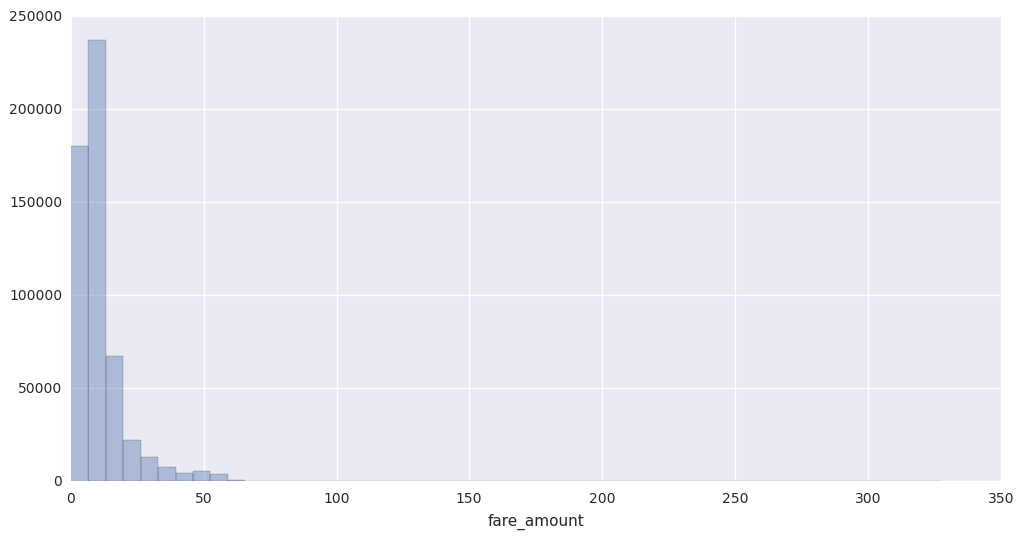

In [210]:
sns.distplot(df['fare_amount'], kde=False)

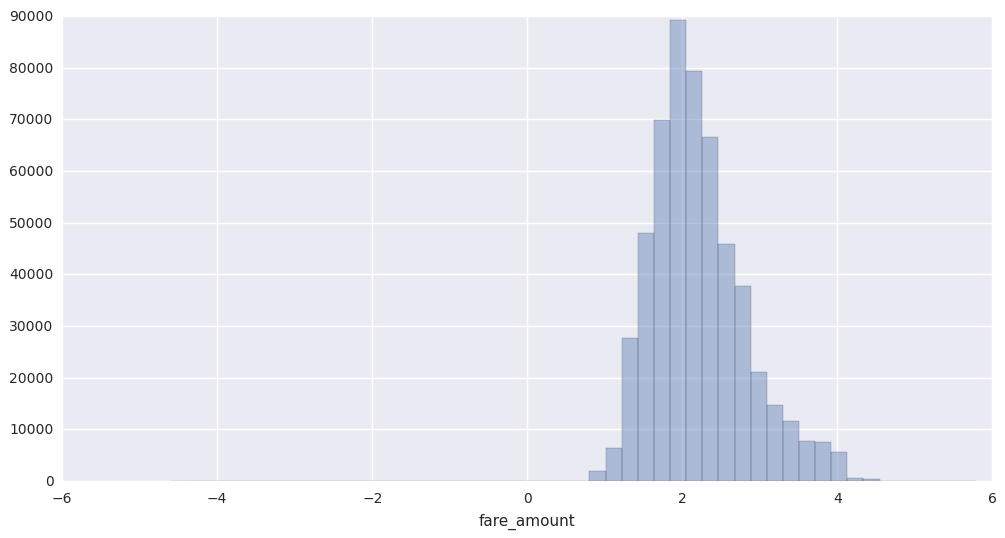

In [211]:
sns.distplot(np.log(df['fare_amount']), kde=False)

### Outliers

In [212]:
df.groupby('pickup_year').agg({'fare_amount':['count', 'mean', 'median']})

fare_amount                  
                  count       mean median
pickup_year                              
2008                 24  12.108333    9.2
2009              84204  10.049609    7.7
2010              81427  10.163905    7.7
2011              86647  10.428355    7.7
2012              86922  11.143688    8.5
2013              84990  12.549644    9.5
2014              80400  12.855194    9.5
2015              37765  12.996763    9.5

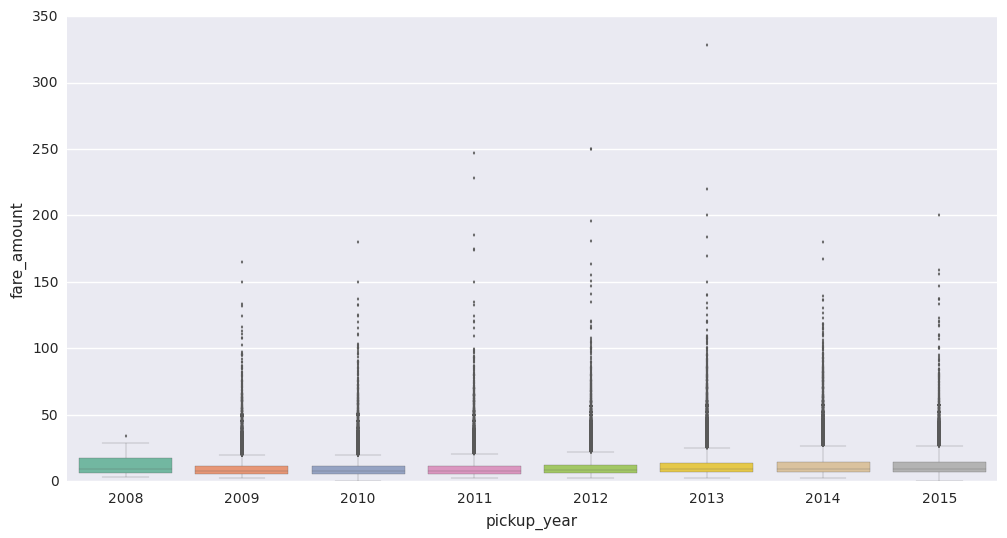

In [213]:
sns.boxplot(
    x='pickup_year',
    y='fare_amount',
    data=df,
    palette='Set2',
    linewidth=0.2,
    fliersize = 2
)

In [214]:
df.groupby('pickup_month').agg({'fare_amount':['count', 'mean', 'median']})

fare_amount                  
                   count       mean median
pickup_month                              
1                  48020  10.717323    8.0
2                  45700  10.920179    8.1
3                  51148  11.138491    8.2
4                  50114  11.298499    8.5
5                  50837  11.572650    8.5
6                  48682  11.492721    8.5
7                  41110  11.022726    8.1
8                  38864  11.303058    8.5
9                  40958  11.697931    8.5
10                 43977  11.608273    8.5
11                 41078  11.546404    8.5
12                 41891  11.542711    8.5

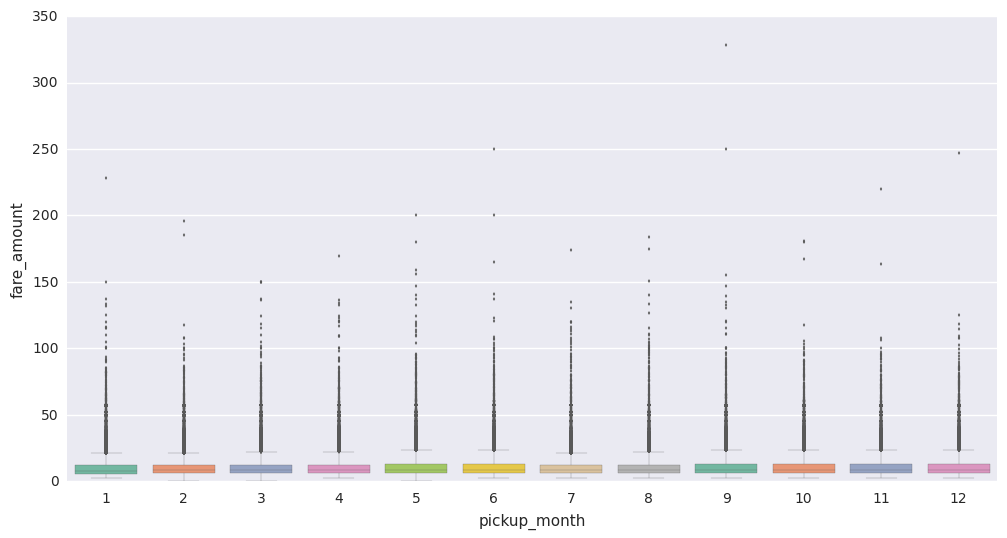

In [215]:
sns.boxplot(
    x='pickup_month',
    y='fare_amount',
    data=df,
    palette='Set2',
    linewidth=0.2,
    fliersize = 2
)

In [216]:
df.groupby('pickup_hour').agg({'fare_amount':['count', 'mean', 'median']})

fare_amount                  
                  count       mean median
pickup_hour                              
0                  5899  13.951173    9.5
1                  7102  13.480401    8.5
2                 14199  11.528406    8.0
3                 20869  11.005704    8.0
4                 25060  10.780308    8.1
5                 25265  10.945176    8.5
6                 24786  10.977760    8.1
7                 25712  11.052866    8.1
8                 26861  11.289340    8.5
9                 26807  11.592655    8.5
10                27137  11.834855    8.5
11                25036  12.037207    8.5
12                24018  11.648861    8.1
13                29310  11.200971    8.5
14                32796  10.811021    8.3
15                32937  10.660043    8.1
16                31578  10.805341    8.5
17                30588  11.042441    8.5
18                28773  11.378914    8.9
19                25266  11.668776    8.9
20                19190  11.637971    9.0
21                14598  11.515453    9.0
22                10779  11.474424    9.0
23                 7813  12.329676    9.5

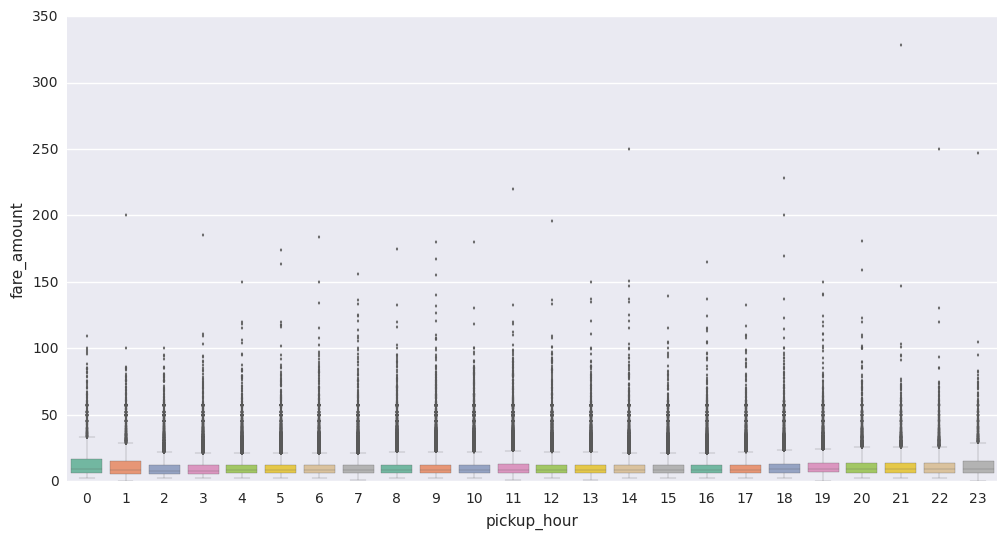

In [217]:
sns.boxplot(
    x='pickup_hour',
    y='fare_amount',
    data=df,
    palette='Set2',
    linewidth=0.2,
    fliersize = 2)

In [218]:
df.groupby(['pickup_day', 'pickup_day_name']).agg({'fare_amount':['count', 'mean', 'median']})

fare_amount                  
                                 count       mean median
pickup_day pickup_day_name                              
0          Monday                69469  11.394285    8.1
1          Tuesday               77308  11.165356    8.5
2          Wednesday             79664  11.308276    8.5
3          Thursday              83392  11.430390    8.5
4          Friday                89909  11.340545    8.5
5          Saturday              83407  10.928149    8.5
6          Sunday                59230  11.774920    8.5

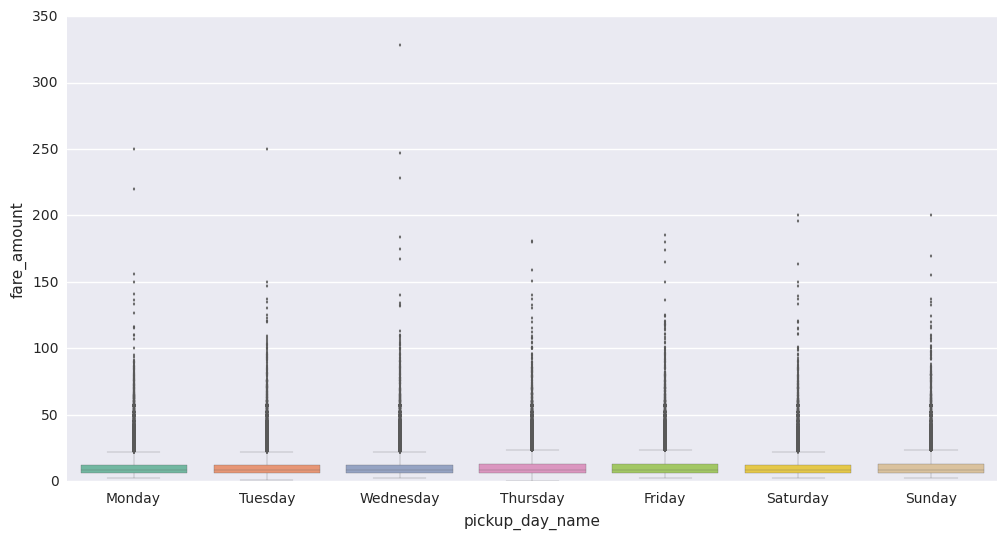

In [219]:
sns.boxplot(
    x='pickup_day_name',
    y='fare_amount',
    data=df.sort_values(by='pickup_day'),
    palette='Set2',
    linewidth=0.2,
    fliersize = 2)

# Model Development and Outputs

We'll start with a linear regression model to account for specific features that we can derive from the datasets readily available.

In [253]:
def lm_rmse(x_df, y):
    X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.2)
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    plt.scatter(y_test, predictions, alpha=0.3)
    plt.xlabel('actual adjusted fare amount')
    plt.ylabel('predicted adjusted fare amount')
    print(np.sqrt(((predictions - y_test) ** 2).mean()))
    return(lm, y_test, predictions)

### Hour of day

In [221]:
df = df.merge(pd.get_dummies(df['pickup_hour']).add_prefix('hour_'), left_index=True, right_index=True)

9.54469854801


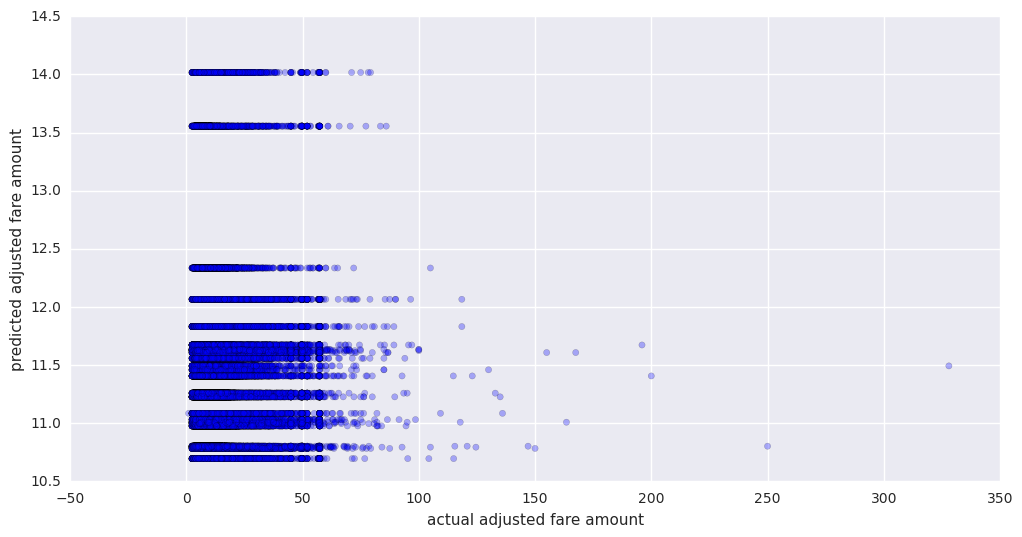

In [254]:
lm, y_test, predictions = lm_rmse(df[['hour_{0}'.format(i) for i in range(24)]], df['fare_amount']) 

### Day of Week

In [223]:
df = df.merge(pd.get_dummies(df['pickup_day_name']), left_index=True, right_index=True)

9.53198855739


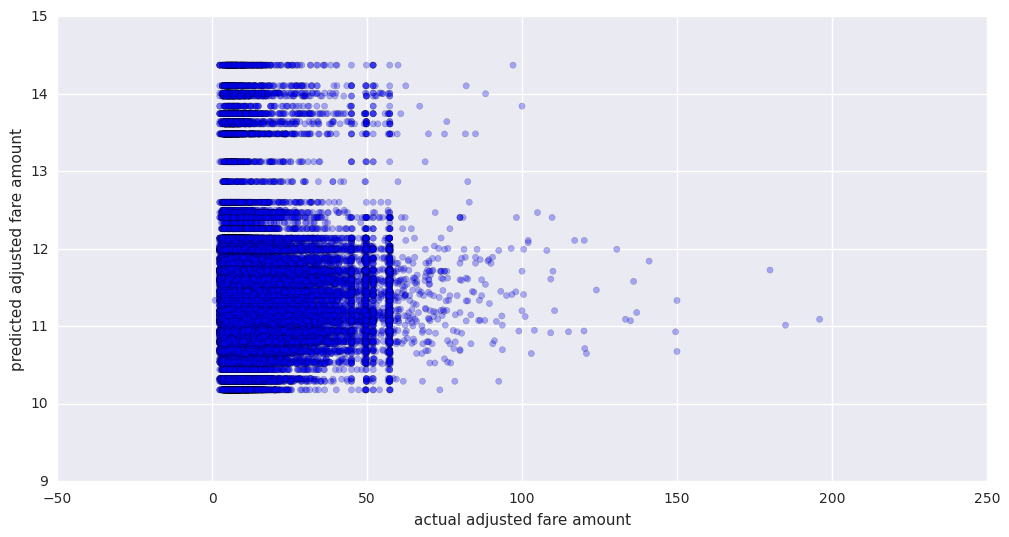

In [255]:
lm, y_test, predictions = lm_rmse(
    df[list(df.pickup_day_name.unique()) + list(['hour_{0}'.format(i) for i in range(24)])], df['fare_amount']) 

### Year

In [225]:
df = df.merge(pd.get_dummies(df['pickup_year']).add_prefix('year_'), left_index=True, right_index=True)

9.44091294007


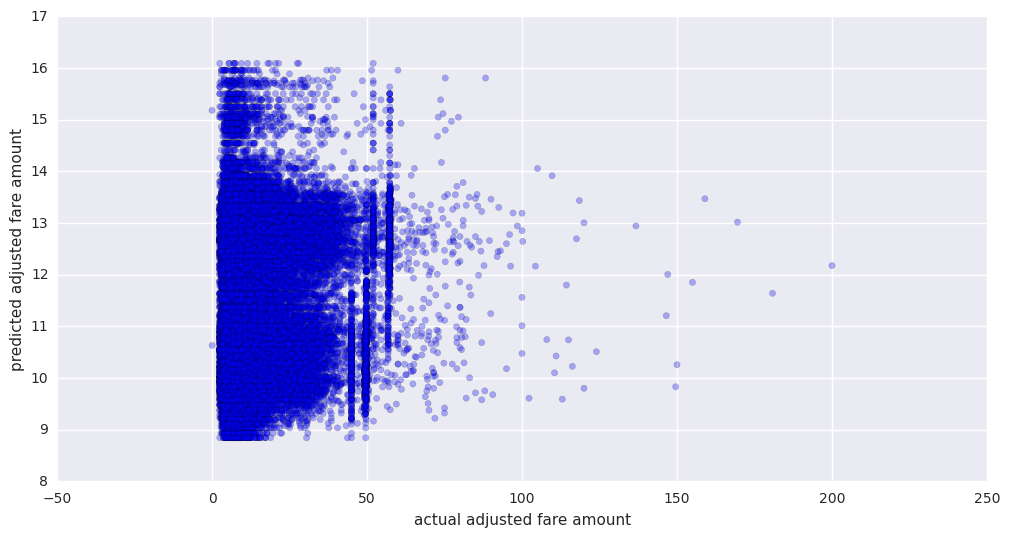

In [256]:
lm, y_test, predictions = lm_rmse(
    df[list(df.pickup_day_name.unique()) 
    + list(['hour_{0}'.format(i) for i in range(24)])
    + list(['year_{0}'.format(i) for i in df.pickup_year.unique()]) ]
    , df['fare_amount']) 

### Miles

4.68396394339


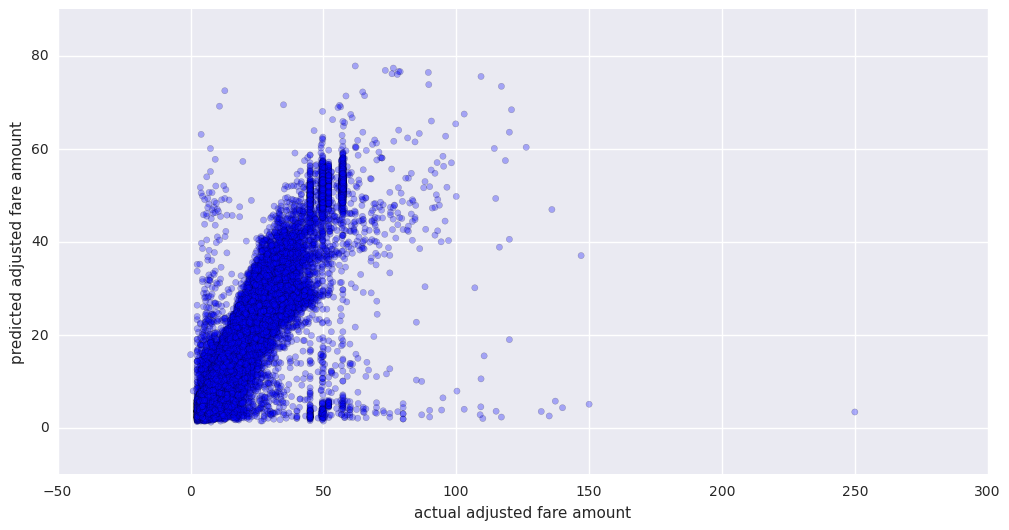

In [257]:
lm, y_test, predictions = lm_rmse(
    df[list(df.pickup_day_name.unique()) 
    + list(['hour_{0}'.format(i) for i in range(24)])
    + list(['year_{0}'.format(i) for i in df.pickup_year.unique()]) 
    + ['miles']]
    , df['fare_amount']) 

### JFK

In [228]:
def miles_to_jfk(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    jfk = (40.646379, -73.789879)
    return min(distance.great_circle(pickup, jfk).miles, distance.great_circle(dropoff, jfk).miles)

In [229]:
df['miles_to_jfk'] = df.apply(miles_to_jfk, axis=1)

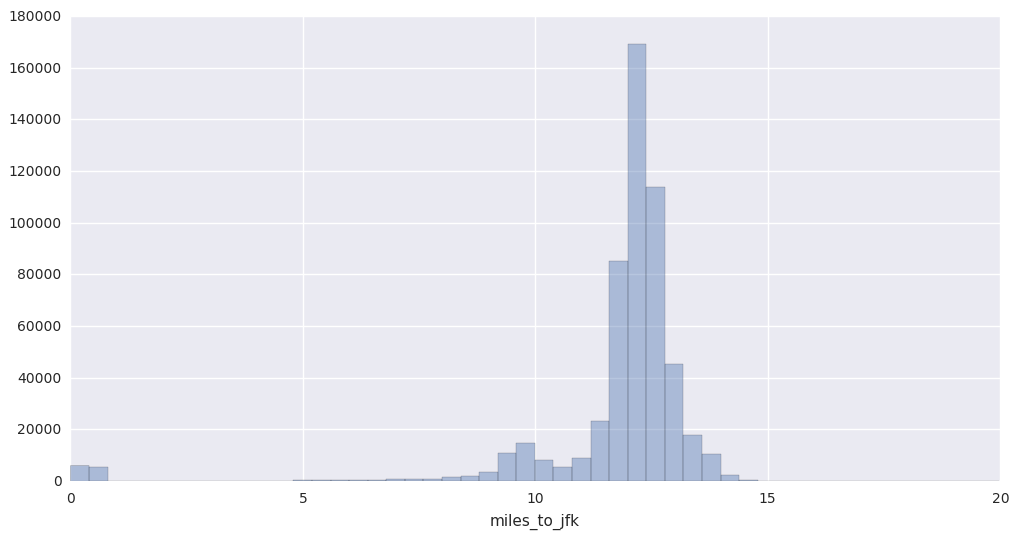

In [230]:
sns.distplot(df[df.miles_to_jfk<20]['miles_to_jfk'], kde=False)

In [231]:
df['jfk'] = 0
df.loc[df.miles_to_jfk<2, 'jfk']=1

4.75001034316


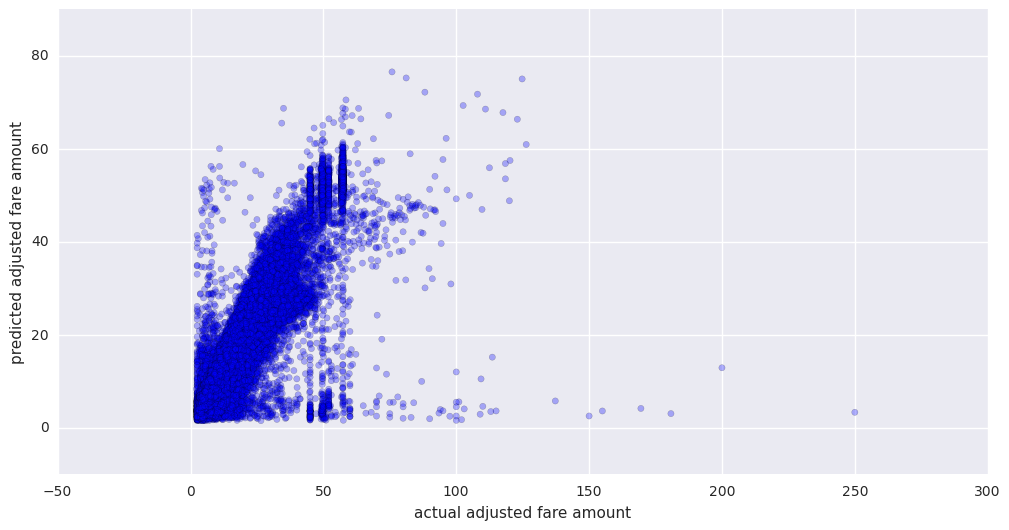

In [260]:
lm, y_test, predictions = lm_rmse(
    df[list(df.pickup_day_name.unique()) + list(['hour_{0}'.format(i) for i in range(24)]) + list(['year_{0}'.format(i) for i in df.pickup_year.unique()]) + ['miles', 'jfk']]
    , df['fare_amount']) 

### Deep dive into highest RMSE records

Some patterns are starting to emerge among the trips that are completely wrong in our model. There are two obvious groups, to start - very expensive trips that are being underestimated (maybe these include tolls, other airports, etc.), and very inexpensive trips that are being overestimated (maybe these are along highways with no tolls and no traffic so they cover a lot of distance in a short period of time).

In [233]:
y_test = pd.DataFrame(y_test)
y_test['prediction'] = predictions

In [234]:
df.merge(y_test, left_index=True, right_index=True, how='inner')\
    .query('fare_amount_y < 25')\
    .query('prediction > 30')\
    .describe()

,index,fare_amount_x,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_hour,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,miles_to_jfk,jfk,fare_amount_y,prediction
count,1.890000e+02,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,...,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,3.020618e+07,17.551323,-73.918484,40.726265,-73.936201,40.770302,1.735450,2010.888889,6.592593,12.132275,...,0.317460,0.153439,0.153439,0.111111,0.052910,0.015873,8.178921,0.296296,17.551323,37.281907
std,1.613472e+07,7.571111,0.123571,0.059452,0.099719,0.073147,1.365947,1.558550,3.182089,6.461709,...,0.466725,0.361368,0.361368,0.315104,0.224448,0.125316,6.512235,0.457836,7.571111,8.427910
min,4.158110e+05,2.500000,-75.084983,40.543265,-74.959702,40.614282,1.000000,2009.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005479,0.000000,2.500000,30.029312
25%,1.448395e+07,9.500000,-73.988952,40.657383,-73.978662,40.716077,1.000000,2010.000000,4.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.717367,0.000000,9.500000,31.244541
50%,3.177473e+07,21.700000,-73.952957,40.741180,-73.937123,40.766565,1.000000,2010.000000,7.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.769812,0.000000,21.700000,33.072350
75%,4.494500e+07,24.100000,-73.801412,40.770171,-73.898353,40.849814,2.000000,2012.000000,9.000000,17.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.467610,1.000000,24.100000,42.475533
max,5.539820e+07,24.900000,-73.738408,40.871971,-73.616988,40.930455,6.000000,2015.000000,12.000000,23.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,61.739951,1.000000,24.900000,61.168697


In [235]:
df.merge(y_test, left_index=True, right_index=True, how='inner')\
    .query('fare_amount_y > 50')\
    .query('prediction < 10')\
    .describe()

,index,fare_amount_x,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_hour,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,miles_to_jfk,jfk,fare_amount_y,prediction
count,1.410000e+02,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,...,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,2.617334e+07,70.265745,-73.948499,40.737126,-73.949477,40.736613,1.283688,2012.156028,6.560284,12.262411,...,0.184397,0.106383,0.099291,0.226950,0.191489,0.099291,12.319691,0.184397,70.265745,4.832038
std,1.587871e+07,33.633728,0.170468,0.075886,0.170844,0.075973,0.679561,1.887113,3.302313,6.006717,...,0.389190,0.309426,0.300118,0.420353,0.394876,0.300118,7.910397,0.389190,33.633728,2.024185
min,3.636500e+04,50.500000,-74.882924,40.483683,-74.888105,40.483685,1.000000,2009.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034942,0.000000,50.500000,1.574368
25%,1.269576e+07,52.500000,-74.015862,40.694607,-74.027900,40.693101,1.000000,2010.000000,4.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.402774,0.000000,52.500000,3.084198
50%,2.496001e+07,57.330000,-73.981709,40.739827,-73.981812,40.739830,1.000000,2013.000000,6.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.722373,0.000000,57.330000,4.813789
75%,4.036204e+07,72.000000,-73.851890,40.762502,-73.851890,40.759478,1.000000,2014.000000,9.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.460319,0.000000,72.000000,5.852421
max,5.531334e+07,328.000000,-73.299293,41.050743,-73.299293,41.050742,5.000000,2015.000000,12.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,57.305567,1.000000,328.000000,9.970337


# Future Model Developments

1. Use all the training data.

2. Cross validate before applying to the test data to avoid overfitting

1. Google Maps API (or other source) to get driving directions for a more accurate distance estimator for each trip.

2. Taxi fare accumulates when cars are traveling slowly, which may be impacted due to weather. We can use the Dark Sky API (or other source) to get an estimate of precipitation or other weather conditions that may slow down the trip and increate the fare in proportion to distance traveled.

3. Consider modeling to predict the log fare amount rather than the far amount directly, as the data is not at all normally distributed as is.

4. Random Forest model is also well suited for this type of linear problem, this would be a logical next step to try. Alternatively, it could be worth clustering the data first to identify different types of trips, for example (a) normal trips that that are just a few miles and correlate closely with distance traveled without traffic, (b) particularly short and expensive trips, (c) particularly long and inexpensive trips, (d) trips that involve lots of tolls and airport fees, (d) interborough trips, etc.

# Taxi App

### Future model improvements

1. GPS data to know exactly where the taxi when, extrapolate speed, etc.

2. Collect toll information

3. Consider how specific drivers (and maybe even passengers) influence the overall far amount. For example, some drivers are better than others, some are more aggressive, some know the city better, etc.

### Understanding users

1. A/B testing to experiment with various model outcomes. For example, if we use this model to show a customer or a driver the expected fare amount that they will pay, is it better to over or underestimate? Is a wide range up front better than an incorrect but exact prediction?
2. Consider user sessions to understand if users are considering taxi alternatives and at what point they make each decision. 
3. Price elasticity to understand how users weigh cost vs. time in different scenarios. Does the presence of alternative transportation such as a subway make a user less likely to take a taxi for a particular type of trip?